In [39]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch_hmc.field import BatchedField
from torch_hmc.mcmc_action import Phi4Action
from tqdm import tqdm

# A single simulation 

In this section, a simple example simulation of $\phi^4$-theory is performed in two spatial dimensions. The parameters set correspond to a system close to criticality, leading to large correlation length, as can be seen in the sample field configuration.

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 256
lin_extent = 128

m2 = -4.0
l = 4.4

batched_field = BatchedField(2, lin_extent, batch_size, device)

# We add a small constant perturbation to the fields for better thermalization in the
# symmetry broken phase
batched_field.set_constant(0.1)

action = Phi4Action(m2, l)

In [41]:
thermalization = 5000

compile_steps = 2   # this defines the number of loops unrolled by the compiler,
                    # tune for best performance

sampling = 5000
dropout = 10  # only record every 10th sample

n_nmd = 30  # number of leapfrog steps
t = 1  # time span between samples, such that dt = t/n_nmd

accepts = torch.zeros([batch_size], device=device, dtype=torch.int32)

mag = torch.zeros((sampling // dropout, batch_size), device="cpu")
mag_therm = torch.zeros((thermalization, batch_size), device="cpu")

correlation_matrix = torch.zeros((batch_size,)  + ((batched_field.lat_len,) * batched_field.dim), device='cpu')


for i in tqdm(range(thermalization)):
    accepts += batched_field.hmc_step(n_nmd, t / n_nmd, action, compile_steps=compile_steps)
    mag_therm[i] = batched_field.compute_magnetization().cpu()


for i in tqdm(range(sampling)):
    accepts += batched_field.hmc_step(n_nmd, t / n_nmd, action, compile_steps)
    if i % dropout == 0:
        mag[i // dropout] = batched_field.compute_magnetization().cpu()
        correlation_matrix += batched_field.compute_correlation().cpu()
        
correlation_matrix /= (sampling // dropout)


print(f"Acceptance rate: {accepts.sum() / ((thermalization + sampling) * batch_size)}")

100%|██████████| 5000/5000 [00:44<00:00, 112.32it/s]

Acceptance rate: 0.8542323708534241


In [42]:
abs_mag = abs(mag).mean(0).mean()
abs_mag_se = abs(mag).mean(0).std() / torch.sqrt(
    torch.tensor(batch_size, dtype=torch.float32)
)

print(f"|m|: {abs_mag} +- {abs_mag_se}")

|m|: 0.0848032683134079 +- 0.0016352662350982428


The evolution of magnetization should be monitored during thermalization, in order to check if the system is close to equilibrium. 

In [43]:
plt.plot(mag_therm[::, ::3].numpy())

plt.xlabel("Simulation time")
plt.ylabel("Magnetization")
plt.title("Thermalization")

plt.grid()
plt.show()

Text(0.5, 1.0, 'Field configuration')

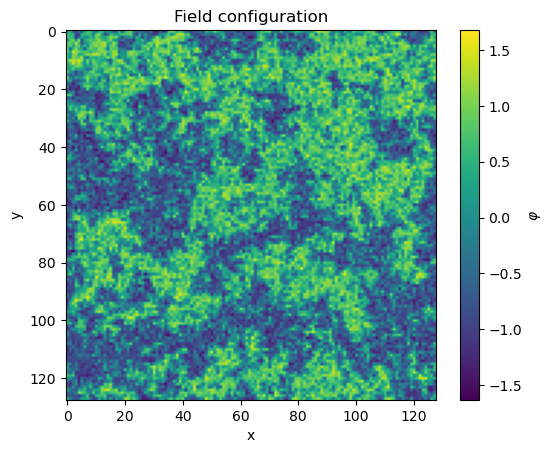

In [44]:
plt.imshow(batched_field.phi[9].cpu())
plt.colorbar(label="$\\varphi$")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Field configuration")

In [45]:
# We can also plot the correlation function
correlation = correlation_matrix.mean(0)[0] / correlation_matrix.mean(0)[0,0]
correlation_err = correlation_matrix.std(0)[0] / correlation_matrix.mean(0)[0,0] / np.sqrt(batch_size)

plt.errorbar(np.arange(correlation.shape[0]), correlation, correlation_err, marker='.')
plt.ylim(0,)

plt.xlabel("$x-x'$")
plt.ylabel("$G(x-x')$")

plt.grid()

# Phase diagram scan

In [16]:
from operator import itemgetter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def simulation(params_dict: dict) -> tuple:
    """
    Runs a single simulation of the phi^4 model and returns observables.

    args:
        params_dict (dict): Dictionary containing the parameters of the simulation.

    returns:
        tuple: Tuple containing the observables of the simulation (mag, mag_se, accept_rate)
    """
    (
        batch_size,
        lin_extent,
        init_field,
        m2,
        l,
        thermalization,
        sampling,
        dropout,
        n_nmd,
        t,
        compile_steps,
    ) = itemgetter(
        "batch_size",
        "lin_extent",
        "init_field",
        "m2",
        "l",
        "thermalization",
        "sampling",
        "dropout",
        "n_nmd",
        "t",
        "compile_steps",
    )(
        params_dict
    )

    batched_field = BatchedField(2, lin_extent, batch_size, device)
    batched_field.set_constant(init_field)

    action = Phi4Action(m2, l)

    accepts = torch.zeros([batch_size], device=device, dtype=torch.int32)

    mag = torch.zeros((sampling // dropout, batch_size), device="cpu")
    mag_therm = torch.zeros((thermalization, batch_size), device="cpu")

    for i in range(thermalization):
        accepts += batched_field.hmc_step(
            n_nmd, t / n_nmd, action, compile_steps=compile_steps
        )
        mag_therm[i] = batched_field.compute_magnetization().cpu()

    for i in range(sampling):
        accepts += batched_field.hmc_step(n_nmd, t / n_nmd, action, compile_steps)
        if i % dropout == 0:
            mag[i // dropout] = batched_field.compute_magnetization().cpu()

    accept_rate = accepts.sum() / ((thermalization + sampling) * batch_size)

    abs_mag = abs(mag).mean(0).mean()
    abs_mag_se = abs(mag).mean(0).std() / torch.sqrt(
        torch.tensor(batch_size, dtype=torch.float32)
    )

    return abs_mag, abs_mag_se, accept_rate.cpu()

In [199]:
dict_params = {
    "batch_size": 256,
    "lin_extent": 64,
    "init_field": 0.1,
    "m2": -5.0,
    "l": 4.4,
    "thermalization": 1000,
    "sampling": 500,
    "dropout": 10,
    "n_nmd": 30,
    "t": 1,
    "compile_steps": 2,
}

# initialize pandas data frame
df = pd.DataFrame(columns=["lambda", "m2", "mag", "mag_se", "accept_rate"])

lambda_sweep = [1/3 + 1/3 * i for i in range(24)]
mass_sweep = [0 - 0.25* i for i in range(21)]

# create unique pairs of lambda and m2
pairs = [(l, m) for l in lambda_sweep for m in mass_sweep] 


dict_list = []
for param_pair in tqdm(pairs):
    torch._dynamo.reset()  # reset compiler cache, so we dont run into limits
    dict_params["l"] = param_pair[0]
    dict_params["m2"] = param_pair[1]
    mag, mag_se, accept_rate = simulation(dict_params)
    dict_list.append(
        {
            "lambda": param_pair[0],
            "m2": dict_params["m2"],
            "mag": mag.numpy(),
            "mag_se": mag_se.numpy(),
            "accept_rate": accept_rate.numpy(),
        }
    )

results = pd.DataFrame(dict_list)

#results.to_csv("phi_4_phase_diag_64.csv", index=False)

100%|██████████| 42/42 [04:40<00:00,  6.69s/it]


In [250]:
# stack the magnetization and magnetization standard error into a tensor
magnetization = torch.zeros((len(lambda_sweep), len(mass_sweep)), device="cpu", dtype=float)

for i, m in enumerate(mass_sweep[::-1]):
    magnetization[:, i] = torch.tensor(results[results["m2"] == m]["mag"].to_numpy(dtype=float))

magnetization = magnetization.T

In [261]:
plt.imshow(magnetization[:,:-3], interpolation="bicubic", cmap="viridis", origin='lower')

#set the x and y ticks
plt.yticks(np.arange(len(mass_sweep))[::4], mass_sweep[::4][::-1])
plt.xticks(np.arange(len(lambda_sweep))[2:-3:3], np.round(lambda_sweep[2:-3:3]))

plt.xlabel("$\lambda$")
plt.ylabel("$m^2$")

plt.colorbar(label="|M| / V")
"Phase di"
plt.title("2D, $V=64^2$")

plt.savefig("phi4_phase_diag_64.png", dpi=500, bbox_inches="tight")

# Volume scan

We now keep perform several scans of the coupling at fixed mass while changing the volume of the system, in order to get an idea about the finite volume effects.

In [17]:
dict_params = {
    "batch_size": 256,
    "lin_extent": 64,
    "init_field": 0.1,
    "m2": -4.0,
    "l": 4.4,
    "thermalization": 1000,
    "sampling": 500,
    "dropout": 10,
    "n_nmd": 30,
    "t": 1,
    "compile_steps": 2,
}

lin_lengths = [8, 16, 32, 64, 128]
couplings = [3.5 + 0.5 / 3 * i for i in range(13)]

pairs = [(v, l) for v in lin_lengths for l in couplings]

dict_list = []
for v, l in tqdm(pairs):
    torch._dynamo.reset()
    dict_params["lin_extent"] = v
    dict_params["l"] = l
        
    mag, mag_se, accept_rate = simulation(dict_params)
    dict_list.append(
        {
            "lambda": l,
            "lin_extent": v,
            "mag": mag.numpy(),
            "mag_se": mag_se.numpy(),
            "accept_rate": accept_rate.numpy(),
        }
    )
    
results_vol_scan = pd.DataFrame(dict_list)

results_vol_scan.to_csv("phi_4_vol_scan.csv", index=False)

100%|██████████| 65/65 [07:33<00:00,  6.98s/it]


In [18]:
import itertools
marker = itertools.cycle(('o', 's', '^', 'v'))

fig, ax = plt.subplots(figsize=(5.5, 3.75))

for lin_length in lin_lengths:
    single_volume_data = torch.tensor(results_vol_scan[results_vol_scan["lin_extent"] == lin_length]["mag"].to_numpy(dtype=float))
    plt.plot(couplings, single_volume_data, label=f"$V={lin_length}^2$", linestyle="--", marker = next(marker), markeredgecolor=(0.25,.25,.25))
    
plt.xlabel("$\lambda$")
plt.ylabel("$|M| / V$")

plt.ylim(0,)

plt.grid()

plt.legend()

plt.savefig("phi4_vol_scan.png", dpi=500, bbox_inches="tight")